<a href="https://colab.research.google.com/github/ssegovba/identifying-deforestation/blob/main/notebooks/classification_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained models

This notebook outlines the data processing and model building and fitting from pre-trained models for our satellite images



## Data Pre-processing

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image

from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/Shareddrives/computer-vision-project/Data/"
train_path = "/content/drive/Shareddrives/computer-vision-project/Data/train-jpg/"
model_path = "/content/drive/Shareddrives/computer-vision-project/Models/"

In [ ]:
# from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import os

In [ ]:
# Load the CSV file with the metadata
labels_df = pd.read_csv(data_path + 'train_classes.csv')

# Add extension so image names match file names
labels_df['image_name'] = labels_df['image_name'].apply(lambda x: x + '.jpg')

# Convert the space-separated tags into a list of tags
labels_df['tags'] = labels_df['tags'].apply(lambda x: x.split())

In [ ]:
unique_tags = labels_df['tags'].explode().unique()

for tag in unique_tags:
    print(tag)

haze
primary
agriculture
clear
water
habitation
road
cultivation
slash_burn
cloudy
partly_cloudy
conventional_mine
bare_ground
artisinal_mine
blooming
selective_logging
blow_down


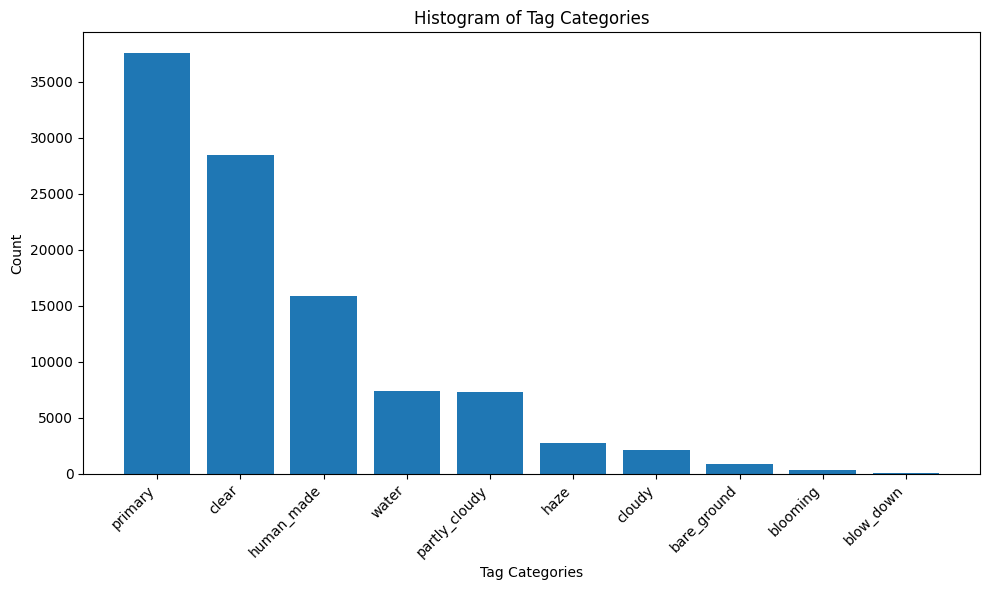

In [ ]:
from collections import Counter
from matplotlib import pyplot as plt

# Define the list of human-made tags
human_tags = ['agriculture', 'road', 'habitation', 'cultivation', 'slash_burn', 'selective_logging', 'conventional_mine', 'artisinal_mine']

# Function to categorize tags as human-made
def categorize_tags_man_made(tags):
    if any(tag in human_tags for tag in tags):
        return ['human_made'] + [tag for tag in tags if tag not in human_tags]
    else:
        return tags

# Apply the categorization function to the tags column
labels_df['tag_category'] = labels_df['tags'].apply(categorize_tags_man_made)
labels_df["image_name"] = train_path + labels_df["image_name"]

# Flatten the list of tag categories
tag_categories_flat = [tag for tags in labels_df['tag_category'] for tag in tags]

# Get the counts of each tag category
tag_category_counts = Counter(tag_categories_flat)

# Sort the tag categories by count in descending order
sorted_tag_categories = sorted(tag_category_counts.items(), key=lambda x: x[1], reverse=True)

# Unzip the sorted categories into two lists: categories and counts
categories, counts = zip(*sorted_tag_categories)

# Plot the sorted tag categories
plt.figure(figsize=(10, 6))
plt.bar(categories, counts)
plt.xlabel('Tag Categories')
plt.ylabel('Count')
plt.title('Histogram of Tag Categories')
plt.xticks(rotation=45, ha='right')  # rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
labels_df["image_name"][100]

'/content/drive/Shareddrives/computer-vision-project/Data/train-jpg/train_100.jpg'

In [ ]:
# image_path = '/content/drive/Shareddrives/computer-vision-project/Data/train-jpg/train_100.jpg'

# image = Image.open(image_path)

# plt.imshow(image)
# plt.axis('off')
# plt.show()

In [ ]:
labels_df['tag_category'].value_counts()

tag_category
[clear, primary]                                     13636
[human_made, clear, primary]                          8099
[partly_cloudy, primary]                              3630
[human_made, clear, primary, water]                   3112
[human_made, partly_cloudy, primary]                  2208
                                                     ...  
[water]                                                  1
[human_made, partly_cloudy, primary, blow_down]          1
[human_made, blooming, blow_down, clear, primary]        1
[human_made, blooming, haze, primary]                    1
[human_made, blow_down, partly_cloudy, primary]          1
Name: count, Length: 75, dtype: int64

### Sample data to see if models run faster

In [ ]:
sampled_df = labels_df.sample(n=39195, random_state=42) # using all data for final
sampled_df.reset_index(drop=True, inplace=True)

In [ ]:
sampled_df.shape

(39195, 3)

In [ ]:
sampled_df["image_name"][0]

'/content/drive/Shareddrives/computer-vision-project/Data/train-jpg/train_34602.jpg'

In [ ]:
sampled_df.head()

,image_name,tags,tag_category
0,/content/drive/Shareddrives/computer-vision-pr...,"[clear, primary, road]","[human_made, clear, primary]"
1,/content/drive/Shareddrives/computer-vision-pr...,"[clear, primary, water]","[clear, primary, water]"
2,/content/drive/Shareddrives/computer-vision-pr...,"[clear, conventional_mine, habitation, primary...","[human_made, clear, primary, water]"
3,/content/drive/Shareddrives/computer-vision-pr...,[cloudy],[cloudy]
4,/content/drive/Shareddrives/computer-vision-pr...,"[agriculture, clear, cultivation, cultivation,...","[human_made, clear, primary, water]"


In [ ]:
# create validataion set
from sklearn.model_selection import train_test_split

In [ ]:
train_df, val_df = train_test_split(sampled_df, test_size=0.2, random_state=42)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 10)

In [ ]:
print(train_df.shape)
print(val_df.shape)

(31356, 3)
(7839, 3)


In [ ]:
train_df['image_name'][0]

'/content/drive/Shareddrives/computer-vision-project/Data/train-jpg/train_27316.jpg'

In [ ]:
image_height = 128
image_width = 128
batch_size = 64

filtered_train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_name',
    y_col='tag_category',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_name',
    y_col='tag_category',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 28859 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2497 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


Found 7200 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 639 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


# Building the Pre-Trained models

In [ ]:
from keras.applications import VGG16, ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler, TensorBoard

In [ ]:
# set number of classes/labels
num_classes = len(set(tag_categories_flat))
num_classes

10

In [ ]:
from keras import backend as K

# from ChatGPT - custom F1 function to be used in metrics when compiling the model

def f1_score(y_true, y_pred):
    # convert predictions to binary values
    y_pred = K.round(y_pred)

    # calculate true positives, false positives, and false negatives
    TP = K.sum(K.round(y_true * y_pred), axis=0)
    FP = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    FN = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)

    # calculate precision and recall
    precision = TP / (TP + FP + K.epsilon())
    recall = TP / (TP + FN + K.epsilon())

    # calculate F1-score
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # average F1-score across all classes
    f1 = K.mean(f1)

    return f1

## Saved ResNet Results from Previous Run that are BAD

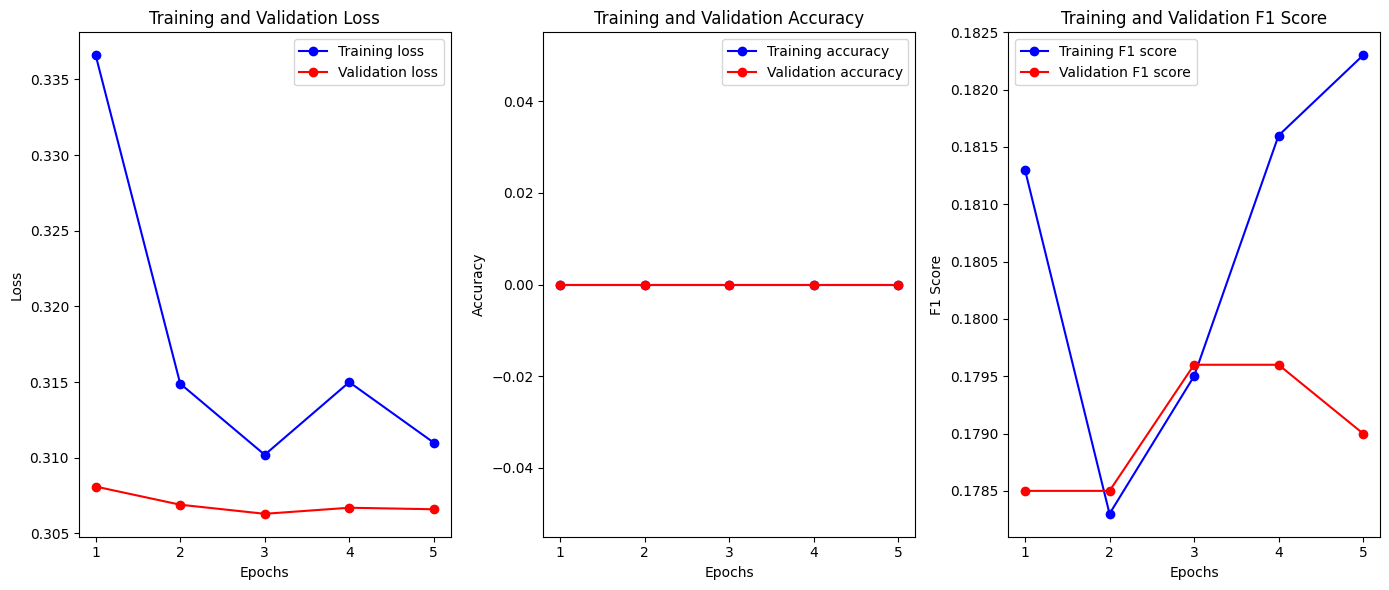

In [ ]:
resnet_hist = {
    'loss': [0.3366, 0.3149, 0.3102, 0.3150, 0.3110],
    'accuracy': [0.0, 0.0, 0.0, 0.0, 0.0],
    'f1_score': [0.1813, 0.1783, 0.1795, 0.1816, 0.1823],
    'val_loss': [0.3081, 0.3069, 0.3063, 0.3067, 0.3066],
    'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0],
    'val_f1_score': [0.1785, 0.1785, 0.1796, 0.1796, 0.1790],
    'lr': [0.0010, 0.0010, 0.0010, 0.0010, 0.0010]
}

def plot_history(history_dict):
    # Extract data from history dictionary
    epochs = range(1, len(history_dict['loss']) + 1)
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    f1_score = history_dict.get('f1_score')
    val_f1_score = history_dict.get('val_f1_score')
    lr = history_dict.get('lr')

    # Plot Loss
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot F1 Score if available
    if f1_score and val_f1_score:
        plt.subplot(1, 3, 3)
        plt.plot(epochs, f1_score, 'bo-', label='Training F1 score')
        plt.plot(epochs, val_f1_score, 'ro-', label='Validation F1 score')
        plt.title('Training and Validation F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(resnet_hist)

## VGG

In [ ]:
# load the VGG model without the top layers (include_top=False)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg_model.layers[:-2]: # unfreeze the last to layers to allow fine-tuning
    layer.trainable = False

# add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9  # reduce learning rate by 10% every 10 epochs
    return lr
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

x = Flatten()(vgg_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='sigmoid')(x)

model_vgg = Model(inputs=vgg_model.input, outputs=predictions)

In [ ]:
model_vgg.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy', f1_score])
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
vgg_history = model_vgg.fit(filtered_train_generator,
                            epochs=10,
                            steps_per_epoch=90,
                            validation_data=val_generator,
                            validation_steps=30,
                            callbacks=[early_stopping, lr_scheduler_callback, tensorboard_callback])

Epoch 1/10
90/90 [==============================] - 7010s 78s/step - loss: 0.2332 - accuracy: 0.0691 - f1_score: 0.3681 - val_loss: 0.1742 - val_accuracy: 0.0531 - val_f1_score: 0.4332 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 4121s 46s/step - loss: 0.1763 - accuracy: 0.0651 - f1_score: 0.4460 - val_loss: 0.1655 - val_accuracy: 0.0370 - val_f1_score: 0.4736 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - 3314s 37s/step - loss: 0.1686 - accuracy: 0.0612 - f1_score: 0.4763 - val_loss: 0.1499 - val_accuracy: 0.0719 - val_f1_score: 0.5314 - lr: 0.0010
Epoch 4/10
90/90 [==============================] - 2663s 30s/step - loss: 0.1639 - accuracy: 0.0601 - f1_score: 0.4944 - val_loss: 0.1556 - val_accuracy: 0.0542 - val_f1_score: 0.4651 - lr: 0.0010
Epoch 5/10
90/90 [==============================] - 2130s 24s/step - loss: 0.1598 - accuracy: 0.0677 - f1_score: 0.5097 - val_loss: 0.1446 - val_accuracy: 0.0870 - val_f1_score: 0.5036 - lr: 0.0010
Epoch 6/10

In [ ]:
# save model
model_path = "/content/drive/Shareddrives/computer-vision-project/Models/"
model_vgg.save("vgg16_model_all_data.keras")

In [ ]:
# save history
import json
import numpy as np

In [ ]:
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, np.generic):
        return obj.item()
    return obj

history_dict = {key: [convert_to_serializable(item) for item in value] for key, value in vgg_history.history.items()}

history_json = json.dumps(history_dict)

with open('vgg_history.json', 'w') as json_file:
    json_file.write(history_json)

In [ ]:
# path in google drive
destination_path = '/content/drive/Shareddrives/computer-vision-project/Models/vgg16_model_all_data_history.json'

In [ ]:
# copy the file to Google Drive
!cp vgg_history.json $destination_path

In [ ]:
# load the JSON file
with open(destination_path, 'r') as json_file:
    loaded_history = json.load(json_file)

# convert lists back to numpy arrays if needed (for compatibility with some calculations)
for key in loaded_history:
    loaded_history[key] = np.array(loaded_history[key])

In [ ]:
loaded_history

{'loss': array([0.23316377, 0.17625865, 0.16862285, 0.1638644 , 0.15978464,
        0.15571307, 0.15234604, 0.1501907 , 0.1479371 , 0.14153783]),
 'accuracy': array([0.06909722, 0.06510416, 0.06117484, 0.06006945, 0.06770834,
        0.07055961, 0.06024306, 0.06944445, 0.08368056, 0.06319445]),
 'f1_score': array([0.36810967, 0.44600689, 0.47631907, 0.49440092, 0.50972033,
        0.50558019, 0.51540893, 0.51208723, 0.53239584, 0.53555244]),
 'val_loss': array([0.17418827, 0.16553369, 0.14991267, 0.15563267, 0.14460403,
        0.14935814, 0.14443642, 0.14130966, 0.14508227, 0.13406467]),
 'val_accuracy': array([0.053125  , 0.03697916, 0.071875  , 0.05416667, 0.08697917,
        0.10989583, 0.059375  , 0.06458333, 0.059375  , 0.07083333]),
 'val_f1_score': array([0.43319324, 0.47362512, 0.53141457, 0.46513379, 0.50362754,
        0.46310455, 0.51003158, 0.53316772, 0.50787675, 0.53927046]),
 'lr': array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
        0.001])}

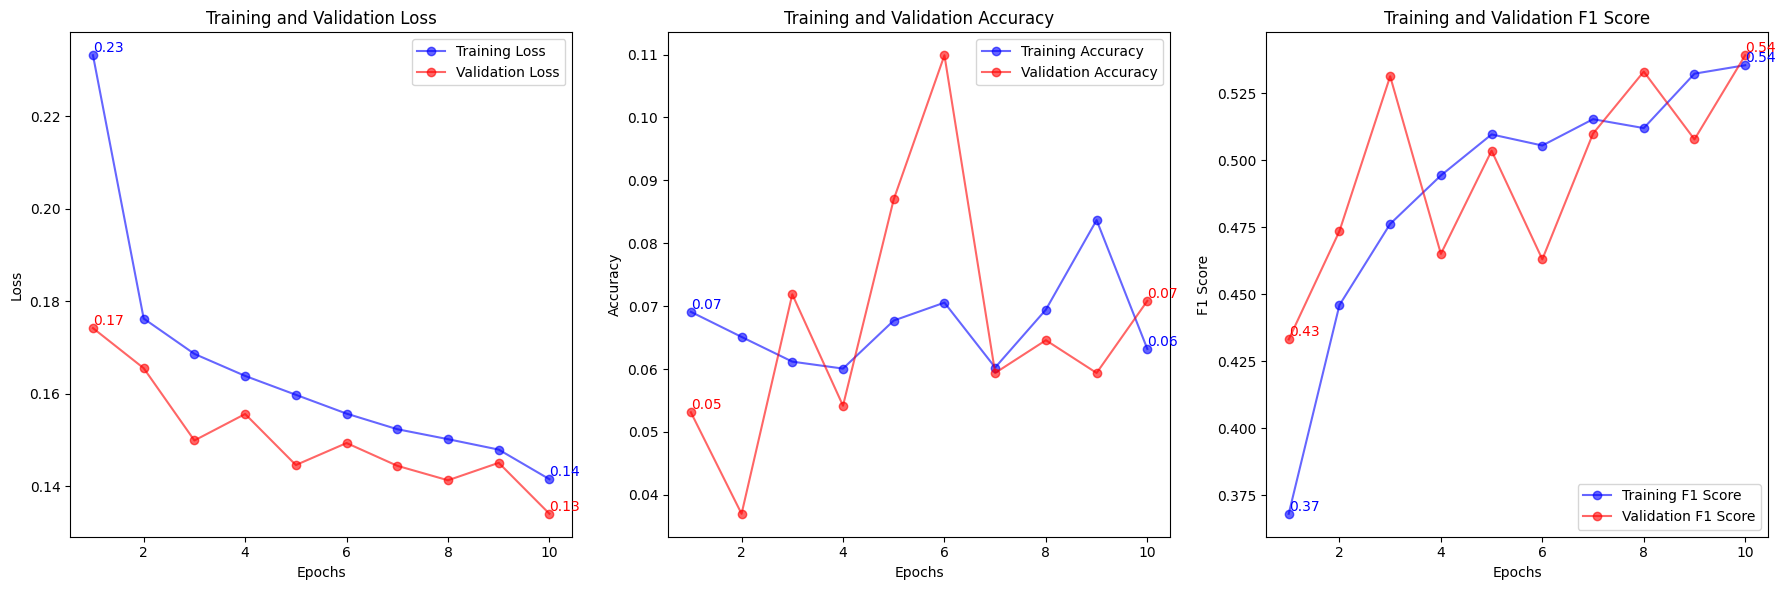

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
    epochs = range(1, len(history['loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['loss'], 'bo-', label='Training Loss', alpha=0.6)
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss', alpha=0.6)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.text(1, history['loss'][0], f'{history["loss"][0]:.2f}', color='blue', va='bottom')
    plt.text(len(epochs), history['loss'][-1], f'{history["loss"][-1]:.2f}', color='blue', va='bottom')
    plt.text(1, history['val_loss'][0], f'{history["val_loss"][0]:.2f}', color='red', va='bottom')
    plt.text(len(epochs), history['val_loss'][-1], f'{history["val_loss"][-1]:.2f}', color='red', va='bottom')

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['accuracy'], 'bo-', label='Training Accuracy', alpha=0.6)
    plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation Accuracy', alpha=0.6)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.text(1, history['accuracy'][0], f'{history["accuracy"][0]:.2f}', color='blue', va='bottom')
    plt.text(len(epochs), history['accuracy'][-1], f'{history["accuracy"][-1]:.2f}', color='blue', va='bottom')
    plt.text(1, history['val_accuracy'][0], f'{history["val_accuracy"][0]:.2f}', color='red', va='bottom')
    plt.text(len(epochs), history['val_accuracy'][-1], f'{history["val_accuracy"][-1]:.2f}', color='red', va='bottom')

    # Plot F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['f1_score'], 'bo-', label='Training F1 Score', alpha=0.6)
    plt.plot(epochs, history['val_f1_score'], 'ro-', label='Validation F1 Score', alpha=0.6)
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.text(1, history['f1_score'][0], f'{history["f1_score"][0]:.2f}', color='blue', va='bottom')
    plt.text(len(epochs), history['f1_score'][-1], f'{history["f1_score"][-1]:.2f}', color='blue', va='bottom')
    plt.text(1, history['val_f1_score'][0], f'{history["val_f1_score"][0]:.2f}', color='red', va='bottom')
    plt.text(len(epochs), history['val_f1_score'][-1], f'{history["val_f1_score"][-1]:.2f}', color='red', va='bottom')

    plt.tight_layout()
    plt.show()

# Assuming loaded_history is the dictionary with your training history
plot_history(loaded_history)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
from keras.models import load_model

loaded_vgg_model = load_model(model_path + "vgg16_model_all_data.keras", custom_objects={'f1_score': f1_score})

KeyboardInterrupt: 

In [ ]:
val_loss, val_accuracy, val_f1_score = loaded_vgg_model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation F1 Score: {val_f1_score}")

  8/113 [=>............................] - ETA: 34:31 - loss: 0.1401 - accuracy: 0.0703 - f1_score: 0.5395

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = loaded_vgg_model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

# get true labels from the validation generator
true_classes = val_generator.classes

113/113 [==============================] - 35s 308ms/step


In [ ]:
for i in range(5):
    print(true_classes[i])

[3, 8]
[6, 3, 8]
[3, 8]
[7, 8]
[7, 8, 9]


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert true_classes to binary matrix
mlb = MultiLabelBinarizer()
true_classes = mlb.fit_transform(true_classes)

# Verify the transformation
print("True classes shape:", true_classes.shape)
print("Sample true classes (binary matrix):")
print(true_classes[:5])

True classes shape: (7200, 10)
Sample true classes (binary matrix):
[[0 0 0 1 0 0 0 0 1 0]
 [0 0 0 1 0 0 1 0 1 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 1 1 1]]


In [ ]:
# Calculate F1 score
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f"Weighted F1 Score: {f1}")

Weighted F1 Score: 0.8707436003897743


In [ ]:
from tensorflow.keras.utils import plot_model
import os

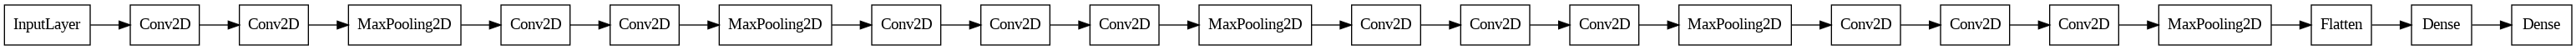

In [ ]:
plot_model(model_vgg, to_file='vgg16_model_simple.png', show_shapes=False, show_layer_names=False, rankdir='LR')

from IPython.display import Image
Image(filename='vgg16_model_simple.png')

# Inception

In [ ]:
from keras.applications import InceptionV3

In [ ]:
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

In [ ]:
for layer in inception_model.layers[:-2]: # unfreeze the last two layers to allow fine-tuning
    layer.trainable = False

# add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9  # reduce learning rate by 10% every 10 epochs
    return lr
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

x = Flatten()(inception_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='sigmoid')(x)

model_inception = Model(inputs=inception_model.input, outputs=predictions)

In [ ]:
model_inception.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy', f1_score])
model_inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 63, 63, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 63, 63, 32)           0         ['batch_normalization[0][0

In [ ]:
inception_history = model_inception.fit(filtered_train_generator,
                            epochs=10,
                            steps_per_epoch=90,
                            validation_data=val_generator,
                            validation_steps=30,
                            callbacks=[early_stopping, lr_scheduler_callback, tensorboard_callback])

Epoch 1/10
90/90 [==============================] - 498s 5s/step - loss: 0.3574 - accuracy: 0.1604 - f1_score: 0.4245 - val_loss: 0.2008 - val_accuracy: 0.1484 - val_f1_score: 0.4716 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 434s 5s/step - loss: 0.2099 - accuracy: 0.1019 - f1_score: 0.4618 - val_loss: 0.1691 - val_accuracy: 0.0729 - val_f1_score: 0.4748 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - 342s 4s/step - loss: 0.1872 - accuracy: 0.1105 - f1_score: 0.4804 - val_loss: 0.1635 - val_accuracy: 0.1323 - val_f1_score: 0.4925 - lr: 0.0010
Epoch 4/10
90/90 [==============================] - 297s 3s/step - loss: 0.1768 - accuracy: 0.1064 - f1_score: 0.4895 - val_loss: 0.1611 - val_accuracy: 0.0953 - val_f1_score: 0.4994 - lr: 0.0010
Epoch 5/10
90/90 [==============================] - 245s 3s/step - loss: 0.1724 - accuracy: 0.1042 - f1_score: 0.4923 - val_loss: 0.1566 - val_accuracy: 0.0885 - val_f1_score: 0.4800 - lr: 0.0010
Epoch 6/10
90/90 [==

In [ ]:
import matplotlib.pyplot as plt

# Performance data from the training log
performance_data = {
    'epoch': list(range(1, 11)),
    'loss': [0.3574, 0.2099, 0.1872, 0.1768, 0.1724, 0.1666, 0.1622, 0.1645, 0.1628, 0.1575],
    'accuracy': [0.1604, 0.1019, 0.1105, 0.1064, 0.1042, 0.0954, 0.1024, 0.0977, 0.0895, 0.0917],
    'f1_score': [0.4245, 0.4618, 0.4804, 0.4895, 0.4923, 0.4989, 0.5121, 0.5111, 0.5146, 0.5121],
    'val_loss': [0.2008, 0.1691, 0.1635, 0.1611, 0.1566, 0.1566, 0.1540, 0.1593, 0.1515, 0.1545],
    'val_accuracy': [0.1484, 0.0729, 0.1323, 0.0953, 0.0885, 0.1245, 0.0385, 0.0719, 0.0573, 0.0547],
    'val_f1_score': [0.4716, 0.4748, 0.4925, 0.4994, 0.4800, 0.4943, 0.4873, 0.4574, 0.5118, 0.5030]
}


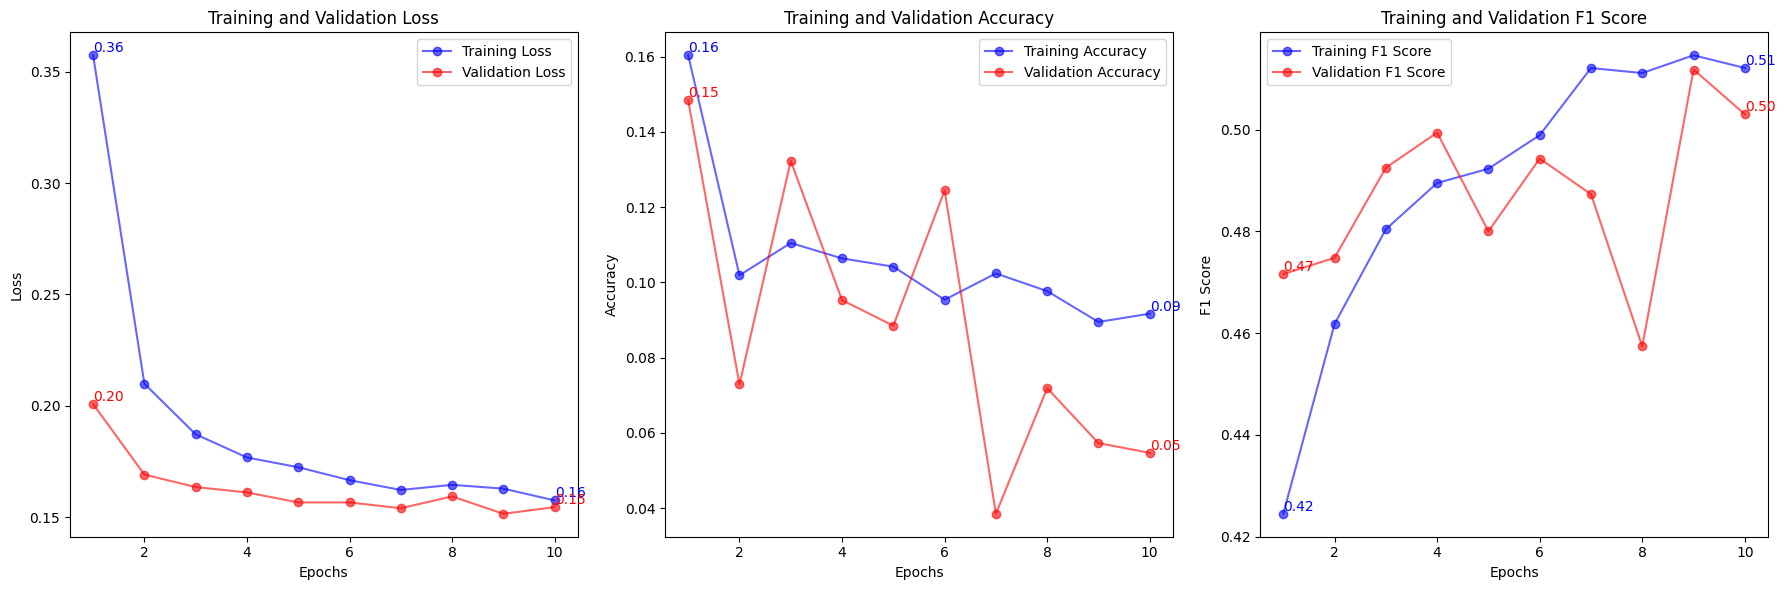

In [ ]:
plot_history(performance_data)

In [ ]:
# save model
model_path = "/content/drive/Shareddrives/computer-vision-project/Models/"
model_inception.save(model_path + "inceptionv3_model_all_data.keras")

In [ ]:
# save history
import json
import numpy as np

In [ ]:
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, np.generic):
        return obj.item()
    return obj

history_dict = {key: [convert_to_serializable(item) for item in value] for key, value in inception_history.history.items()}

history_json = json.dumps(history_dict)

with open('inception_history.json', 'w') as json_file:
    json_file.write(history_json)

NameError: name 'json' is not defined

In [ ]:
# path in google drive
destination_path = '/content/drive/Shareddrives/computer-vision-project/Models/vgg16_model_all_data_history.json'

In [ ]:
# copy the file to Google Drive
!cp inception_history.json $destination_path

In [ ]:
# load the JSON file
with open(destination_path, 'r') as json_file:
    loaded_history = json.load(json_file)

# convert lists back to numpy arrays if needed (for compatibility with some calculations)
for key in loaded_history:
    loaded_history[key] = np.array(loaded_history[key])

In [ ]:
loaded_history

# Evaluating Predictions Further

In [ ]:
from keras.models import load_model

# Load the saved models
vgg16_model = load_model(model_path + "vgg16_model_all_data.keras", custom_objects={'f1_score': f1_score})
inceptionv3_model = load_model(model_path + "inceptionv3_model_all_data.keras", custom_objects={'f1_score': f1_score})

### Predict on Validation Data

In [ ]:
# Get predictions from both models
vgg16_predictions = vgg16_model.predict(val_generator)
inceptionv3_predictions = inceptionv3_model.predict(val_generator)

# Convert predictions to class labels
vgg16_predicted_classes = np.argmax(vgg16_predictions, axis=1)
inceptionv3_predicted_classes = np.argmax(inceptionv3_predictions, axis=1)

# Get true labels from the validation generator
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

113/113 [==============================] - 38s 303ms/step


In [ ]:
# Convert predictions to binary format using a threshold of 0.5
vgg16_predicted_classes = (vgg16_predictions > 0.5).astype(int)
inceptionv3_predicted_classes = (inceptionv3_predictions > 0.5).astype(int)

# Get true labels from the validation generator and binarize them
true_classes = val_generator.classes
mlb = MultiLabelBinarizer()
true_classes_binary = mlb.fit_transform(true_classes)
class_labels = mlb.classes_

In [ ]:
class_labels = val_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  # Invert the dictionary to map indices to class names
class_labels_list = [class_labels[i] for i in range(len(class_labels))]

mlb = MultiLabelBinarizer(classes=class_labels_list)
true_classes_binary = mlb.fit_transform([[class_labels[i] for i in x] for x in true_classes])

print("Class Index to Label Mapping:")
for index, label in enumerate(mlb.classes_):
    print(f"{index}: {label}")

Class Index to Label Mapping:
0: bare_ground
1: blooming
2: blow_down
3: clear
4: cloudy
5: haze
6: human_made
7: partly_cloudy
8: primary
9: water


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Calculate F1 scores for each model
vgg16_report = classification_report(true_classes_binary, vgg16_predicted_classes, target_names=mlb.classes_, output_dict=True)
inceptionv3_report = classification_report(true_classes_binary, inceptionv3_predicted_classes, target_names=mlb.classes_, output_dict=True)

# Extract F1 scores for each class
vgg16_f1_scores = [vgg16_report[label]['f1-score'] for label in mlb.classes_]
inceptionv3_f1_scores = [inceptionv3_report[label]['f1-score'] for label in mlb.classes_]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

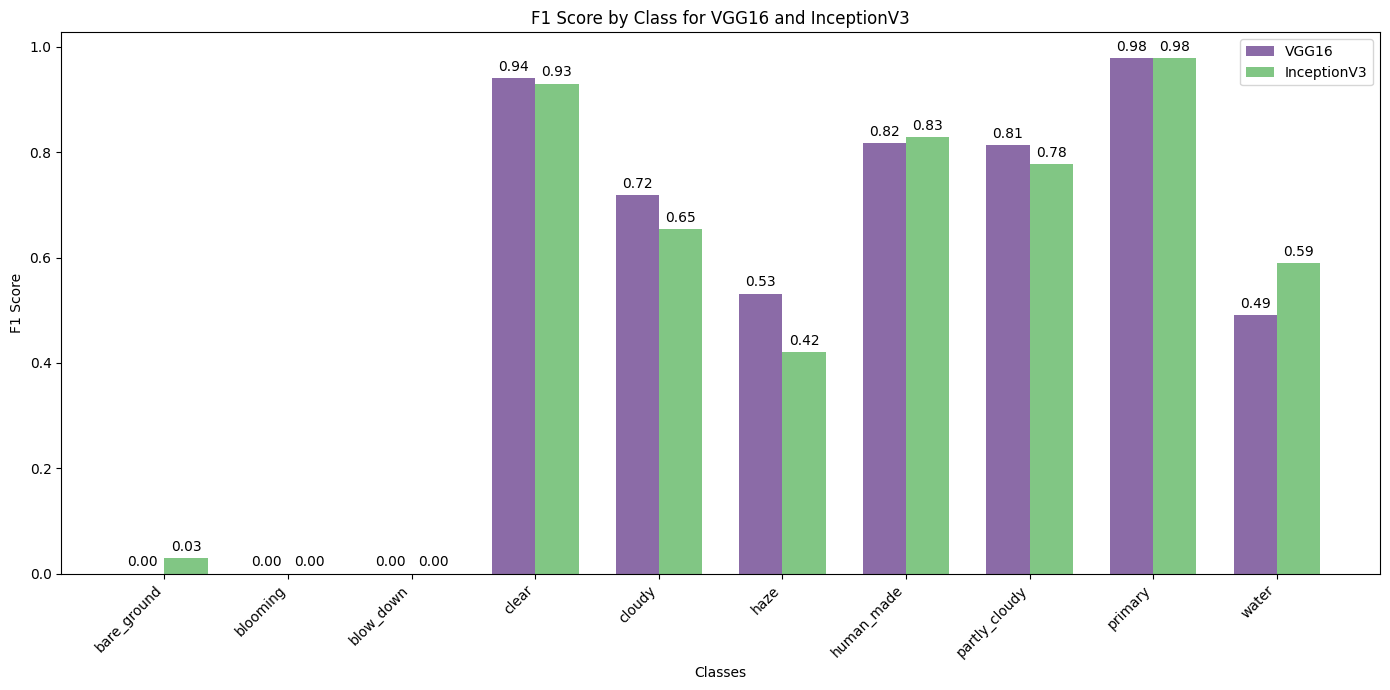

In [ ]:
import matplotlib.pyplot as plt

# Create a bar graph
x = np.arange(len(mlb.classes_))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 7))

# Customize colors
vgg16_color = '#5A2D82'  # Dark Purple
inceptionv3_color = '#4CAF50'  # Green

rects1 = ax.bar(x - width/2, vgg16_f1_scores, width, label='VGG16', alpha=0.7, color=vgg16_color)
rects2 = ax.bar(x + width/2, inceptionv3_f1_scores, width, label='InceptionV3', alpha=0.7, color=inceptionv3_color)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score by Class for VGG16 and InceptionV3')
ax.set_xticks(x)
ax.set_xticklabels(mlb.classes_, rotation=45, ha='right')
ax.legend()

# Add labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


In [ ]:
from keras.utils.vis_utils import plot_model
import os

ModuleNotFoundError: No module named 'keras.utils.vis_utils'